In [19]:
import time
import os
import numpy as np
import sys
sys.path.append("..")
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


In [20]:
from util.experiment import set_seeds, get_args
from torch.utils.data import random_split, DataLoader
from model.autoencoder import ConvAutoEncoder
from model.classifier import LinearClassifier
from model.classifier import E2eClassifier
from train.train import train_autoencoder, train_classifier
from eval.eval import val_autoencoder, val_classifier
from dataset.dataset4individual import Dataset4Individual
from util.experiment import CustomScheduler


In [21]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

In [22]:
# Define the datasets and dataloaders
print('Loading datasets and dataloaders ...')
id = 'e0017MC'
batch_size=30
phase = ['Encoding', 'SameDayRecall', 'NextDayRecall']
seeg_dir = '/oscar/data/brainstorm-ws/seeg_data/Memory Task Data/Epilepsy/Monitoring'
dataset = Dataset4Individual(id, phase, seeg_dir)
train_size = int(0.9 * len(dataset))
num_workers= 2
val_size = len(dataset) - train_size
print(f'Train size: {train_size}, Val size: {val_size}')
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


Loading datasets and dataloaders ...
Train size: 75, Val size: 9


In [23]:
def extract_data_and_labels(currdataset):
    seeg_data = []
    labels = []
    for i in range(len(dataset)):
        seeg, video_idx, phase = dataset[i]
        seeg_data.append(seeg)
        labels.append(video_idx)  # Assuming you want both video_idx and phase as labels
    return np.array(seeg_data), np.array(labels)

# Extract sEEG data and labels for training and validation/testing sets
seeg_train, label_train  = extract_data_and_labels(train_dataset)
seeg_test, label_test = extract_data_and_labels(val_dataset)  # Assuming val_dataset is used for testing/validation


In [24]:
seeg_train.shape # movie, electrodes, times

(84, 234, 5120)

In [25]:
label_train.shape # movie

(84,)

In [26]:
seeg_test.shape

(84, 234, 5120)

In [27]:
label_test.shape

(84,)

In [28]:
num_samples, num_electrodes, num_timepoints = seeg_train.shape
seeg_train_flat = seeg_train.reshape(num_samples, num_electrodes * num_timepoints)


scaler = StandardScaler()
seeg_train_flat = scaler.fit_transform(seeg_train_flat)

# Choose the number of components, e.g., 85% of variance
pca = PCA(n_components=0.85)
seeg_train_pca = pca.fit_transform(seeg_train_flat)
print(seeg_train_pca.shape)

(84, 33)


In [29]:
seeg_train_pca_reduced = seeg_train_pca[:, :8]

In [30]:
label_train.shape

(84,)

In [31]:
x.shape

(84,)

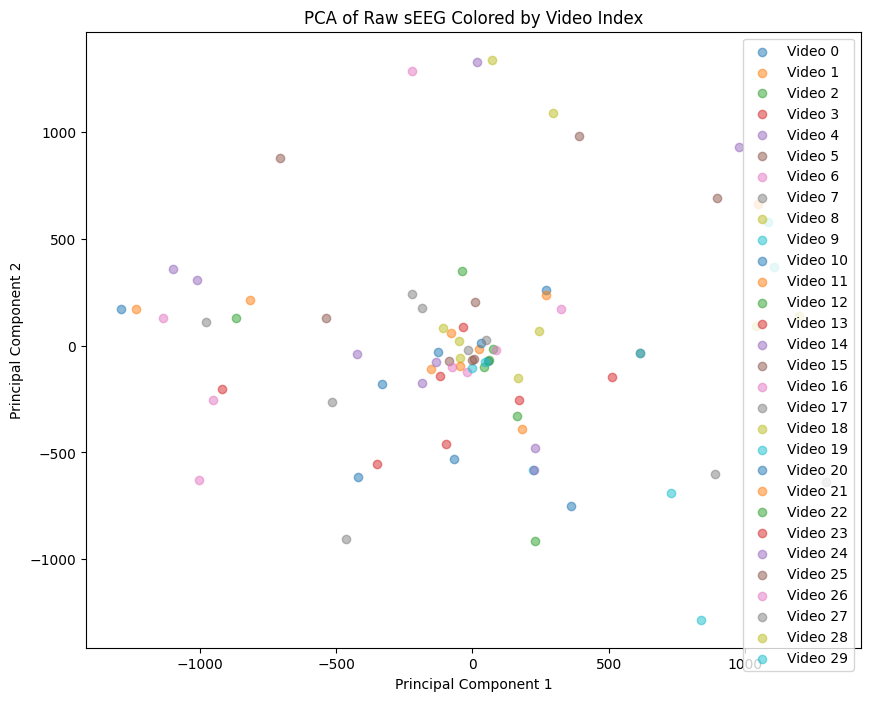

In [32]:
# Assuming embeddings_pca is your PCA-reduced embeddings and labels contains video_idx

# Extract the two dimensions
x = seeg_train_pca[:, 0]  # First principal component
y = seeg_train_pca[:, 1]  # Second principal component

# Create a scatter plot, coloring by video_idx
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed

# Iterate through unique video indices to plot each with a unique color
unique_video_idxs = np.unique(label_train)
for video_idx in unique_video_idxs :
    # Indices of points belonging to the current video_idx
    indices = np.where(label_train == video_idx)[0]  # Only use the first element of the tuple
    plt.scatter(x[indices], y[indices], label=f'Video {video_idx}', alpha=0.5)



# Add legend and labels
plt.legend()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Raw sEEG Colored by Video Index')
plt.show()


In [33]:
num_samples, num_electrodes, num_timepoints = seeg_test.shape
seeg_test_flat = seeg_test.reshape(num_samples, num_electrodes * num_timepoints)


scaler = StandardScaler()
seeg_test_flat = scaler.fit_transform(seeg_test_flat)


# Choose the number of components, e.g., 99% of variance
pca = PCA(n_components=0.99)
seeg_test_pca = pca.fit_transform(seeg_test_flat)
print(seeg_test_pca.shape)


(84, 75)


In [36]:
# Print the shape of the PCA-transformed data
print(seeg_train_pca.shape)

# Print the explained variance ratio for each component
print("Explained variance ratio by each component:", pca.explained_variance_ratio_)

# Print the cumulative explained variance
cumulative_explained_variance = np.sum(pca.explained_variance_ratio_)
print("Cumulative explained variance:", cumulative_explained_variance)

# If you want to see the explained variance by each component
print("Explained variance by each component:", pca.explained_variance_)


(84, 33)
Explained variance ratio by each component: [0.27279472 0.19440402 0.0827659  0.05713371 0.02161118 0.01950134
 0.01452402 0.01099849 0.01069096 0.01017737 0.00924724 0.00919083
 0.00853164 0.0083326  0.00826724 0.00781667 0.00757601 0.00749586
 0.00732142 0.00708323 0.00695835 0.00690358 0.00664578 0.00640197
 0.00631096 0.00617759 0.00604365 0.00567486 0.00560971 0.00552543
 0.00550982 0.00541967 0.00530585 0.00522309 0.00509429 0.00495098
 0.00478861 0.00466084 0.00458664 0.00453393 0.00440448 0.00435622
 0.0043015  0.00408811 0.00405226 0.00396387 0.00388841 0.00383306
 0.00365428 0.00356272 0.00350935 0.0033776  0.00328545 0.00322384
 0.00313584 0.00303558 0.00298124 0.00282144 0.00275348 0.00269574
 0.00260254 0.00254411 0.00251287 0.00244392 0.00237263 0.00218694
 0.00214149 0.00210393 0.00203174 0.00194514 0.00192352 0.00186801
 0.00179043 0.00174868 0.00163495]
Cumulative explained variance: 0.9905654
Explained variance by each component: [330767.22   235717.45   1003

In [37]:
from model.autoencoder import ConvAutoEncoder
from model.classifier import LinearClassifier

In [38]:
import torch

# # Assuming you have a function to create your model architecture

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# # Load the model weights from a checkpoint
# checkpoint_path = '../experiments/baseline/ckpt/best-e2e-classifier.pth'

# # Load the autoencoder model
# autoencoder = ConvAutoEncoder().to(device)
# checkpoint = torch.load(checkpoint_path, map_location=device)
# autoencoder.load_state_dict(checkpoint['autoencoder'])
# autoencoder.eval() 


In [39]:
model = E2eClassifier().to(device)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Load the model weights from a checkpoint
checkpoint_path = '../experiments/baseline/ckpt/best-e2e-classifier.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['classifier'])  
model.eval() 

E2eClassifier(
  (autoencoder): ConvAutoEncoder(
    (initial_conv1d): Sequential(
      (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): ReLU(inplace=True)
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): ReLU(inplace=True)
      (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (7): ReLU(inplace=True)
      (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (10): ReLU(inplace=True)
      (11): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (encoder_conv2d): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool

In [40]:
embeddings = []
labels = []

with torch.no_grad():
    for seeg, video_idx, phase in DataLoader(dataset, batch_size=1, shuffle=False):
        seeg = seeg.to(device)

        output, embed= model.autoencoder(seeg)
        embeddings.append(embed.cpu().numpy())  # Assuming 'recon' is the embedding you're interested in
        labels.append(video_idx.numpy())  # Keep track of labels if needed

# Concatenate all embeddings and labels
embeddings = np.concatenate(embeddings, axis=0)
labels = np.concatenate(labels, axis=0)


In [41]:
embeddings.shape

(84, 512, 14, 20)

In [42]:
embeddings= embeddings.reshape(84,-1)

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardize the embeddings
scaler = StandardScaler()
embeddings_standardized = scaler.fit_transform(embeddings)

# Apply PCA to reduce dimensions, e.g., to retain 95% of variance
pca = PCA(n_components=0.95)
embeddings_pca = pca.fit_transform(embeddings_standardized)

# Now, embeddings_pca contains the PCA-reduced embeddings


In [44]:
embeddings_pca.shape

(84, 43)

In [45]:
from sklearn.decomposition import PCA

# Assuming you have already created and fit a PCA model named 'pca'
# For example: pca = PCA(n_components=0.95).fit(data)

# Access the explained variance ratio for each component
explained_var_ratios = pca.explained_variance_ratio_

# Print the explained variance ratio of each component
for i, ratio in enumerate(explained_var_ratios, start=1):
    print(f"Principal Component {i}: {ratio:.4f} or {ratio*100:.2f}% of the variance")


Principal Component 1: 0.2586 or 25.86% of the variance
Principal Component 2: 0.1746 or 17.46% of the variance
Principal Component 3: 0.1239 or 12.39% of the variance
Principal Component 4: 0.0783 or 7.83% of the variance
Principal Component 5: 0.0576 or 5.76% of the variance
Principal Component 6: 0.0360 or 3.60% of the variance
Principal Component 7: 0.0296 or 2.96% of the variance
Principal Component 8: 0.0175 or 1.75% of the variance
Principal Component 9: 0.0167 or 1.67% of the variance
Principal Component 10: 0.0133 or 1.33% of the variance
Principal Component 11: 0.0111 or 1.11% of the variance
Principal Component 12: 0.0104 or 1.04% of the variance
Principal Component 13: 0.0094 or 0.94% of the variance
Principal Component 14: 0.0091 or 0.91% of the variance
Principal Component 15: 0.0080 or 0.80% of the variance
Principal Component 16: 0.0074 or 0.74% of the variance
Principal Component 17: 0.0068 or 0.68% of the variance
Principal Component 18: 0.0057 or 0.57% of the varianc

In [46]:
import matplotlib.pyplot as plt
import numpy as np

In [47]:
labels.shape

(84,)

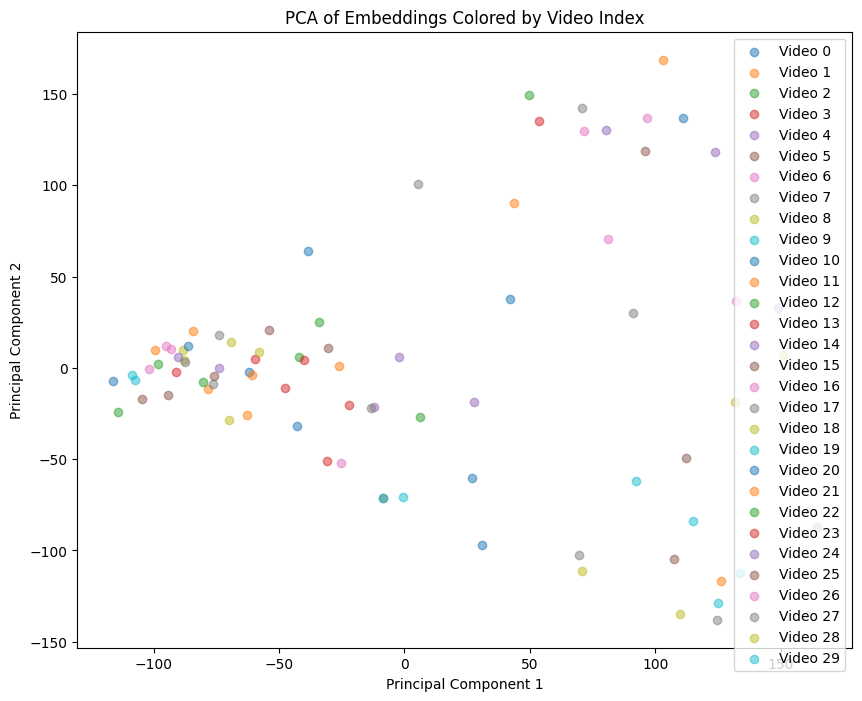

In [48]:
# Assuming embeddings_pca is your PCA-reduced embeddings and labels contains video_idx

# Extract the two dimensions
x = embeddings_pca[:, 0]  # First principal component
y = embeddings_pca[:, 1]  # Second principal component

# Create a scatter plot, coloring by video_idx
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed

# Iterate through unique video indices to plot each with a unique color
unique_video_idxs = np.unique(labels)
for video_idx in unique_video_idxs:
    # Indices of points belonging to the current video_idx
    indices = np.where(labels == video_idx)[0]  # Only use the first element of the tuple
    plt.scatter(x[indices], y[indices], label=f'Video {video_idx}', alpha=0.5)

# Add legend and labels
plt.legend()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Embeddings Colored by Video Index')
plt.show()


In [49]:
from sklearn.manifold import TSNE

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

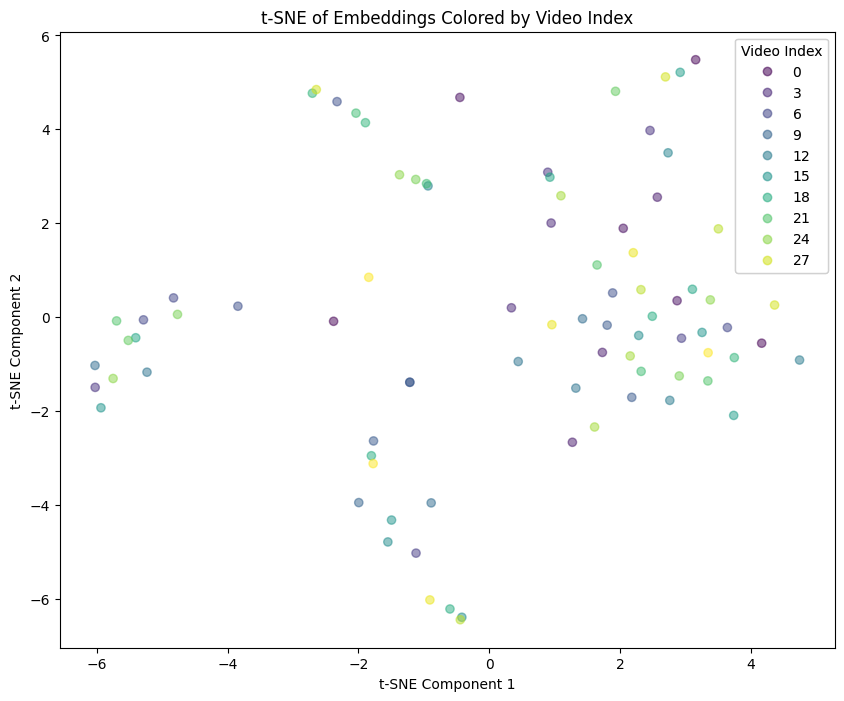

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

# Assuming `embeddings` is your original embeddings data and `labels` contains video_idx

# Perform t-SNE on the embeddings
# Note: t-SNE can be computationally intensive, so you might adjust parameters like `n_components` and `perplexity`
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
embeddings_tsne = tsne.fit_transform(embeddings)

# Extract the two dimensions
x = embeddings_tsne[:, 0]  # First t-SNE component
y = embeddings_tsne[:, 1]  # Second t-SNE component

# Create a scatter plot, coloring by video_idx
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed

# Scatter plot with colors
scatter = plt.scatter(x, y, c=labels, alpha=0.5)

# Create a legend
# First, generate a list of unique labels and sort them
unique_labels = np.unique(labels)
# Then, create a legend by mapping each unique label to its color in the scatter plot
legend1 = plt.legend(*scatter.legend_elements(), title="Video Index")
plt.gca().add_artist(legend1)

# Add labels and title
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE of Embeddings Colored by Video Index')
plt.show()


OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

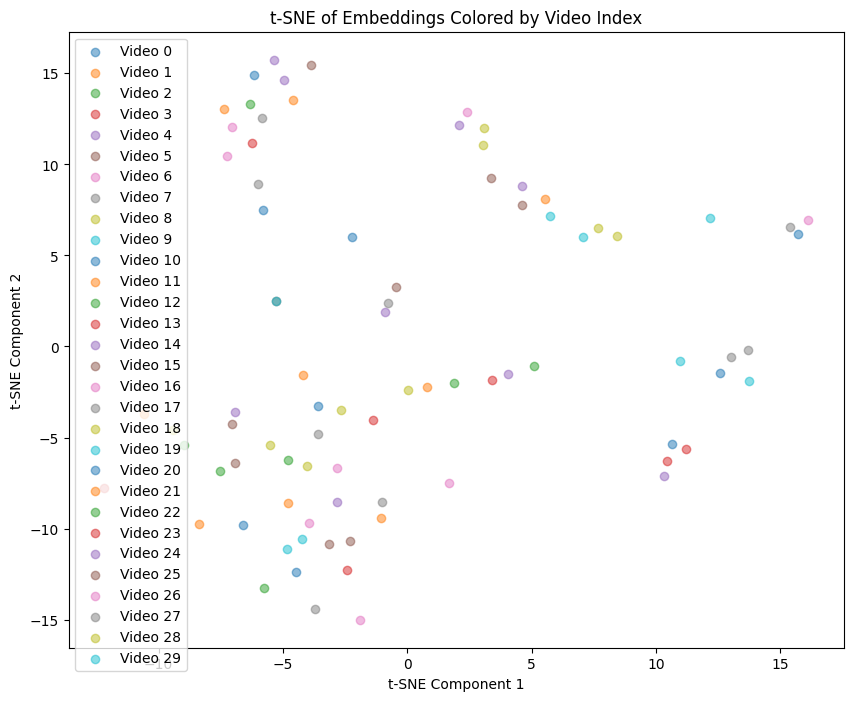

In [54]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

# Assuming `embeddings` is your original embeddings data and `labels` contains video_idx

# Perform t-SNE on the embeddings
# Note: t-SNE can be computationally intensive, so you might adjust parameters like `n_components` and `perplexity`
tsne = TSNE(n_components=2, perplexity=10, n_iter=300)
embeddings_tsne = tsne.fit_transform(embeddings)

# Extract the two dimensions
x = embeddings_tsne[:, 0]  # First t-SNE component
y = embeddings_tsne[:, 1]  # Second t-SNE component

# Create a scatter plot, coloring by video_idx
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed

# # Scatter plot with colors
# scatter = plt.scatter(x, y, c=labels, alpha=0.5)

unique_video_idxs = np.unique(labels)
for video_idx in unique_video_idxs:
    # Indices of points belonging to the current video_idx
    indices = np.where(labels == video_idx)[0]  # Only use the first element of the tuple
    plt.scatter(x[indices], y[indices], label=f'Video {video_idx}', alpha=0.5)

# # Create a legend
# # First, generate a list of unique labels and sort them
# unique_labels = np.unique(labels)
# # Then, create a legend by mapping each unique label to its color in the scatter plot
# legend1 = plt.legend(*scatter.legend_elements(), title="Video Index")
# plt.gca().add_artist(legend1)
plt.legend()
# Add labels and title
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE of Embeddings Colored by Video Index')
plt.show()



